# Web Vulnerability Finding tool: Malicious URL Predictor Workbook

In [9]:
# Install dependencies
! pip install nltk sklearn pandas matplotlib seaborn

You should consider upgrading via the 'c:\users\sumit\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score

print("--Libraries Imported--")

--Libraries Imported--


In [6]:
data_set = pd.read_csv("phishing_site_urls.csv")
data_set.dropna(inplace=True)
data_set = data_set.iloc[0:100000, :]

print("--Dataset Imported Successfully--")

--Dataset Imported--


In [7]:
train_set, test_set = train_test_split(data_set,test_size=0.3)
train_labels = train_set['Class']
test_labels = test_set['Class']


-- Numbers of URLs --

Traning Samples:  70000
Testing Samples:  30000


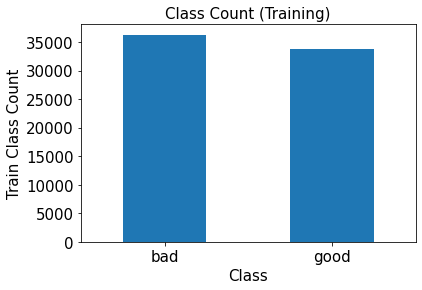

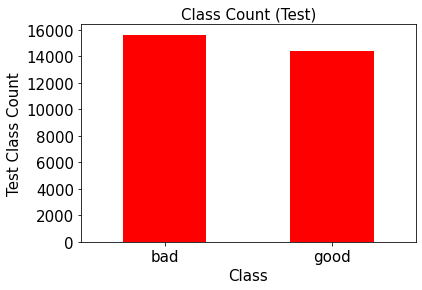

In [8]:
#plotting and printing Class Counts of Test and Training Samples 
print("\n-- Numbers of URLs --\n")
print("Traning Samples: ", len(train_set))
print("Testing Samples: ", len(test_set))

#Bar Graph of Training Set
count_train = pd.value_counts(train_set['Class'])
count_train.plot(kind='bar', fontsize=15)
plt.title("Class Count (Training)", fontsize=15)
plt.xticks(rotation='horizontal')
plt.xlabel("Class", fontsize=15)
plt.ylabel("Train Class Count", fontsize=15)
plt.show()

#Bar Graph of Test Set
count_test = pd.value_counts(test_set['Class'])
count_test.plot(kind='bar', color='red', fontsize=15)
plt.title("Class Count (Test)", fontsize=15)
plt.xticks(rotation='horizontal')
plt.xlabel("Class", fontsize=15)
plt.ylabel("Test Class Count", fontsize=15)
plt.show()

In [9]:
#Tokenization
#Eg Url: www.sumit-singh/bisht.com
def tokenizer(url):
    
    #split by slash (/) and dash (-)
    tokens = re.split('[/-]', url)
    
    for i in tokens:
        #Split domains and subdomains
        if i.find(".") >= 0:
            dot_split = i.split('.')
            
            #removing .com and www. 
            if "com" in dot_split:
                dot_split.remove("com")
            if "www" in dot_split:
                dot_split.remove("www")
                
            tokens += dot_split
            
    return tokens

In [11]:
#Tokenize a URL
test_url = data_set['URLs'][17]
print("\n--Test URL--")
print(test_url)

print("\n--Tokenized URL--")
tokenized_url = tokenizer(test_url)
print(tokenized_url)


--Test URL--
dutchweb.gtphost.com/zimbra/exch/owa/uleth/index.html

--Tokenized URL--
['dutchweb.gtphost.com', 'zimbra', 'exch', 'owa', 'uleth', 'index.html', 'dutchweb', 'gtphost', 'index', 'html']


In [12]:
#Vectorize the data

#Training vectorizers on Training Set
print("\n--Training Count Vectorizer--")
cvec = CountVectorizer(tokenizer = tokenizer)
count_x = cvec.fit_transform(train_set['URLs'])

print("--Training Tf-idf Vectoriizer--")
tvec = TfidfVectorizer(tokenizer=tokenizer)
tfidf_x = tvec.fit_transform(train_set['URLs'])

print("\nVectorizing Complete.\n")



--Training Count Vectorizer--
--Training Tf-idf Vectoriizer--

Vectorizing Complete.



In [13]:
#Displaying the Test URL token
for token in tokenized_url:
    print("{} -> {}".format(tokenized_url.count(token), token))


1 -> dutchweb.gtphost.com
1 -> zimbra
1 -> exch
1 -> owa
1 -> uleth
1 -> index.html
1 -> dutchweb
1 -> gtphost
1 -> index
1 -> html


In [14]:
#Test and evaluate the models
#Vectorizing the testing data
print("\n--Count Vectorizer--")
test_count_x = cvec.transform(test_set['URLs'].values.astype('str'))

print("--Tf-idf Vectorizer--\n")
test_tfidf_x = tvec.transform(test_set['URLs'].values.astype('str'))

print("\n--Vectorizing Complete--\n")



--Count Vectorizer--
--Tf-idf Vectorizer--


--Vectorizing Complete--



In [15]:
#Report Generator function 
def generate_report(cmatrix, score, creport, model):
    cmatrix = cmatrix.T
    
    #generate cmatrix heatmap
    plt.figure(figsize=(6,6))
    sns.heatmap(cmatrix, 
                annot=True, 
                fmt="d", 
                linewidths=.5, 
                square=True,
                cmap = 'Blues',
                annot_kws={"size": 18},
                xticklabels=['bad', 'good'], 
                yticklabels=['bad', 'good'])
    
    plt.xticks(rotation='horizontal', fontsize=15)
    plt.yticks(rotation='horizontal', fontsize=15)
    plt.xlabel('Actual Label', size=17)
    plt.ylabel('Predicted Label', size=17)
    
    title = '{} Accuracy Score: {:.4f}'.format(model, score)
    plt.title(title, fontsize=15)
    
    print('\n--{} Classification Report--\n'.format(model))
    print(creport)
    plt.show()
    
print("\n--Report Generated--\n")


--Report Generated--




--MultinomialNB with Tfidf Model Built--


--MNB (Tfidf) Classification Report--

              precision    recall  f1-score   support

         bad       0.94      0.98      0.96     15627
        good       0.97      0.93      0.95     14373

    accuracy                           0.95     30000
   macro avg       0.96      0.95      0.95     30000
weighted avg       0.96      0.95      0.95     30000



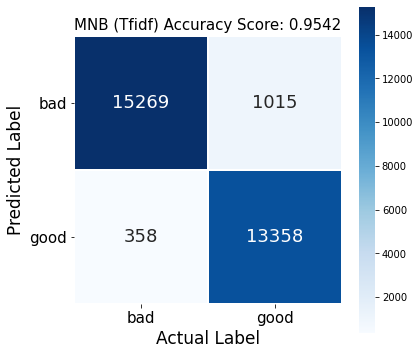

In [16]:
#MultinomialNB Model with Tf-idf Vectorizer
mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(tfidf_x, train_labels)

#Evalutaion Metrics (Score, predictions, confusion matrix, classification report)
score_mnb_tfidf = mnb_tfidf.score(test_tfidf_x, test_labels)
predictions_mnb_tfidf = mnb_tfidf.predict(test_tfidf_x)
cmatrix_mnb_tfidf = confusion_matrix(test_labels, predictions_mnb_tfidf)
creport_mnb_tfidf = classification_report(test_labels, predictions_mnb_tfidf)

print("\n--MultinomialNB with Tfidf Model Built--\n")
generate_report(cmatrix_mnb_tfidf, score_mnb_tfidf, creport_mnb_tfidf,
                "MNB (Tfidf)")


--MultinomialNB with Count Model Built--


--MNB (Count) Classification Report--

              precision    recall  f1-score   support

         bad       0.95      0.97      0.96     15627
        good       0.96      0.94      0.95     14373

    accuracy                           0.96     30000
   macro avg       0.96      0.96      0.96     30000
weighted avg       0.96      0.96      0.96     30000



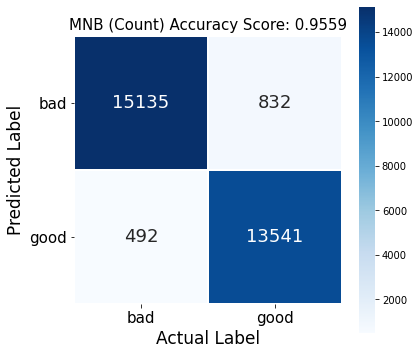

In [17]:
#MultinomialNB Model with Count Vectorizer
mnb_count = MultinomialNB()
mnb_count.fit(count_x, train_labels)

#Evalutaion Metrics (Score, predictions, confusion matrix, classification report)
score_mnb_count = mnb_count.score(test_count_x, test_labels)
predictions_mnb_count = mnb_count.predict(test_count_x)
cmatrix_mnb_count = confusion_matrix(test_labels, predictions_mnb_count)
creport_mnb_count = classification_report(test_labels, predictions_mnb_count)

print("\n--MultinomialNB with Count Model Built--\n")
generate_report(cmatrix_mnb_count, score_mnb_count, creport_mnb_count,
                "MNB (Count)")


--Logistic Regression with Tfidf Model Built--


--LGS (Tfidf) Classification Report--

              precision    recall  f1-score   support

         bad       0.97      0.87      0.92     15627
        good       0.87      0.97      0.92     14373

    accuracy                           0.92     30000
   macro avg       0.92      0.92      0.92     30000
weighted avg       0.92      0.92      0.92     30000



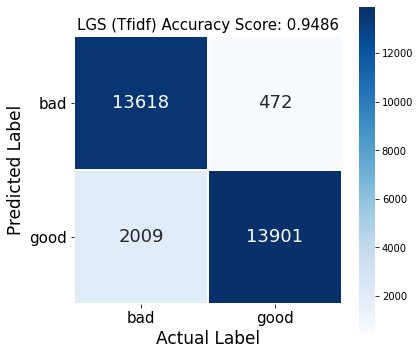

In [18]:
#Logistic Regression Model with Tf-idf
lgs_tfidf = LogisticRegression(max_iter=1000)
lgs_tfidf.fit(tfidf_x, train_labels)

#Evalutaion Metrics (Score, predictions, confusion matrix, classification report)
score_lgs_tfidf = lgs_tfidf.score(test_tfidf_x, test_labels)
predictions_lgs_tfidf = lgs_tfidf.predict(test_count_x)
cmatrix_lgs_tfidf = confusion_matrix(test_labels, predictions_lgs_tfidf)
creport_lgs_tfidf = classification_report(test_labels, predictions_lgs_tfidf)

print("\n--Logistic Regression with Tfidf Model Built--\n")
generate_report(cmatrix_lgs_tfidf, score_lgs_tfidf, creport_lgs_tfidf,
                "LGS (Tfidf)")


--Logistic Regression with Count Model Built--


--LGS (Count) Classification Report--

              precision    recall  f1-score   support

         bad       0.98      0.94      0.96     15627
        good       0.93      0.98      0.96     14373

    accuracy                           0.96     30000
   macro avg       0.96      0.96      0.96     30000
weighted avg       0.96      0.96      0.96     30000



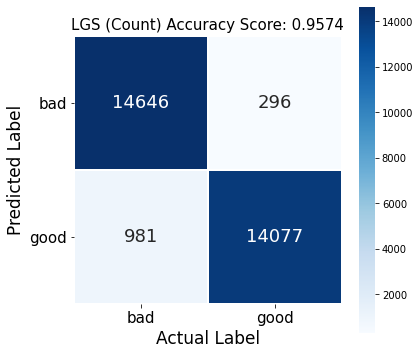

In [19]:
#Logistic Regression Model with Count Vectorizer
lgs_count = LogisticRegression(max_iter=1000)
lgs_count.fit(count_x, train_labels)

#Evalutaion Metrics (Score, predictions, confusion matrix, classification report)
score_lgs_count = lgs_count.score(test_count_x, test_labels)
predictions_lgs_count = lgs_count.predict(test_count_x)
cmatrix_lgs_count = confusion_matrix(test_labels, predictions_lgs_count) 
creport_lgs_count = classification_report(test_labels, predictions_lgs_count)

print("\n--Logistic Regression with Count Model Built--\n")
generate_report(cmatrix_lgs_count, score_lgs_count, creport_lgs_count,
                "LGS (Count)")